## Plot model performance

Visualize performance on different models from a CSV summary file.

In [2]:
import pathlib
import itertools

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import wandb

from utils import BodeColorPalette
bode_palette = BodeColorPalette()

In [3]:
# settings
sns.set_theme(context="paper", 
              style="white", 
              font_scale=0.7,
              rc={"savefig.transparent": True, 
                  "axes.grid": False, 
                  "axes.spines.bottom": True,
                  "axes.spines.left": False,
                  "axes.spines.right": False,
                  "axes.spines.top": False,
                  "font.family":'sans-serif',
                  #"font.sans-serif":["Helvetica", "Arial"],
                  "xtick.major.pad": 0.0,
                  "xtick.minor.pad": 0.0,
                  "ytick.major.pad": 0.0,
                  "ytick.minor.pad": 0.0,
                  "axes.labelweight": "bold",
                  "axes.labelpad": 2.5,  # standard is 4.0
                  "axes.xmargin": .05,
                 }, 
             )

# more settings for all plots
errorbar = "se"  # standard error of the mean
errwidth = .9
errcolor = "black"
capsize = .1  # size of the end of the errorbar
linewidth = 1.  # width of the outline of barplot

palette = [
    bode_palette.blues[0], 
    bode_palette.oranges[0],
    bode_palette.blues[2],
    bode_palette.oranges[2],
    bode_palette.blues[3],
    bode_palette.oranges[3]
]


### Get data from wandb API

In [36]:
def get_runs_as_list(project="jugoetz/synferm-predictions", filters={}):
    api = wandb.Api()
    runs = api.runs(project, filters=filters)
    summary_list, config_list, name_list, tag_list = [], [], [], []
    for run in runs:
        # .summary contains output keys/values for
        # metrics such as accuracy.
        #  We call ._json_dict to omit large files
        summary_list.append(run.summary._json_dict)
    
        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        config_list.append(
            {k: v for k,v in run.config.items()
             if not k.startswith('_')})
    
        tag_list.append(tuple(run.tags))  # tuple b/c we will need to hash it later
    
        # .name is the human-readable name of the run.
        name_list.append(run.name)
    return summary_list, config_list, tag_list, name_list

In [37]:
summary_list, config_list, tag_list, name_list  = get_runs_as_list(filters={"$or":
                                                             [{"jobType": "training"},
                                                              {"jobType": "hparam_best"}
                                                             ]})
df_all = pd.json_normalize(config_list).merge(pd.json_normalize(summary_list), left_index=True, right_index=True)
df_all["tags"] = tag_list
df_all["run_id"] = name_list
df_all["run_group"] = [s.rsplit("_", maxsplit=1)[0] for s in name_list]
df_all["Model+Features"] = df_all["name"] + "/" + df_all["decoder.global_features"].str.join("+").str.replace("None", "CGR")

In [50]:
# check available experiments by split

for tag, row in df_all.groupby("tags")[["experiment_id"]].agg(set).iterrows():
    print(tag, "-->", row["experiment_id"])

('0D',) --> {'JG1106', 'JG1115', 'JG1117', 'JG1100', nan, 'JG1116', 'JG1109'}
('1D',) --> {'JG1118', 'JG1101', nan, 'JG1104'}
('2D',) --> {'JG1119', 'JG1112', nan, 'JG1102', 'JG1105'}
('3D',) --> {'JG1108', 'JG1110', 'JG1120', 'JG1107', 'JG1103', 'JG1111', 'JG1114', nan, 'JG1113'}


## 0D split

In [23]:
# set dir where we will save plots
analysis_dir = pathlib.Path("results")

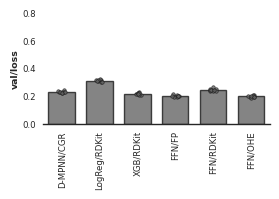

In [24]:
# choose the metric, i.e. accuracy or AUROC
metric = "val/loss"
# choose the task (0D, 1D, or 2D)
tag = "0D"
# choose the colorscheme
fill_color = '0.4'  # grey
stroke_color = '0.1'  # almost black

# choose the data to plot
experiment_ids = [
    "JG1100",
    "JG1106",
    "JG1109",
    "JG1115",
    "JG1116",
    "JG1117",
]

# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(experiment_ids) & df_all['tags'].apply(lambda x: tag in x)]

# sort the values
sort_dict = dict(zip(experiment_ids, itertools.count()))
df_plot = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict))
ticklabels = df_plot["Model+Features"].unique().tolist()
# set plot
fig, ax = plt.subplots(figsize=(2.8,2))
sns.barplot(
    ax=ax,
    data=df_plot, 
    x="Model+Features",
    y=metric,
    errorbar=errorbar,
    errwidth=errwidth,
    errcolor=errcolor,
    capsize=capsize,
    color=fill_color,
    edgecolor=stroke_color,
    linewidth=linewidth,
    alpha=.8,
    width=.7,
)

sns.stripplot(
    ax=ax,
    data=df_plot, 
              x="Model+Features",
              y=metric,
              dodge=True,
              edgecolor=stroke_color,
              color=fill_color,
              linewidth=.5,
              legend=False,
              marker="o",
              size=2.5,
              alpha=.8
             )

#ax.axhline(0.5, ls="--", color=bode_palette.blue, linewidth=.7)
ax.set_xlabel(None)
ax.xaxis.set_tick_params(labelrotation=90)
ax.set_ylim((0.0, 0.8))
ax.xaxis.set_ticklabels(df_plot["Model+Features"].drop_duplicates().str.replace("LogisticRegression", "LogReg"))

fig.tight_layout()

fig.savefig(analysis_dir / f"metrics_{tag}_models_{metric.replace('/', '_')}.svg", format="svg")
fig.savefig(analysis_dir / f"metrics_{tag}_models_{metric.replace('/', '_')}.png", dpi=300)

## 1D split

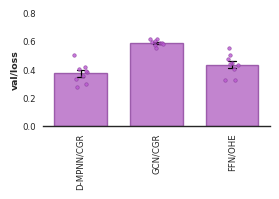

In [25]:
# choose the metric, i.e. accuracy or AUROC
metric = "val/loss"
# choose the task (0D, 1D, or 2D)
tag = "1D"
# choose the colorscheme
fill_color = (189/256, 87/256, 213/256)
stroke_color = (140/256, 67/256, 158/256)

# choose the data to plot
experiment_ids = [
    "JG1101",
    "JG1104",
    "JG1118",

]

# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(experiment_ids) & df_all['tags'].apply(lambda x: tag in x)]

# sort the values
sort_dict = dict(zip(experiment_ids, itertools.count()))
df_plot = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict))
ticklabels = df_plot["Model+Features"].unique().tolist()
# set plot
fig, ax = plt.subplots(figsize=(2.8,2))
sns.barplot(
    ax=ax,
    data=df_plot, 
    x="Model+Features",
    y=metric,
    errorbar=errorbar,
    errwidth=errwidth,
    errcolor=errcolor,
    capsize=capsize,
    color=fill_color,
    edgecolor=stroke_color,
    linewidth=linewidth,
    alpha=.8,
    width=.7,
)

sns.stripplot(
    ax=ax,
    data=df_plot, 
              x="Model+Features",
              y=metric,
              dodge=True,
              edgecolor=stroke_color,
              color=fill_color,
              linewidth=.5,
              legend=False,
              marker="o",
              size=2.5,
              alpha=.8
             )

#ax.axhline(0.5, ls="--", color=bode_palette.blue, linewidth=.7)
ax.set_xlabel(None)
ax.xaxis.set_tick_params(labelrotation=90)
ax.set_ylim((0, 0.8))
ax.xaxis.set_ticklabels(df_plot["Model+Features"].drop_duplicates().str.replace("LogisticRegression", "LogReg"))

fig.tight_layout()
fig.savefig(analysis_dir / f"metrics_{tag}_models_{metric.replace('/', '_')}.svg", format="svg")
fig.savefig(analysis_dir / f"metrics_{tag}_models_{metric.replace('/', '_')}.png", dpi=300)

## 2D split

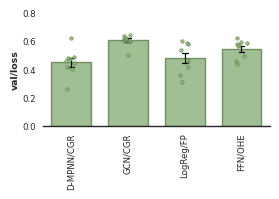

In [26]:
# choose the metric, i.e. accuracy or AUROC
metric = "val/loss"
# choose the task (0D, 1D, or 2D)
tag = "2D"
# choose the colorscheme
fill_color = (
    135/256,
    186/256,
    112/256,
)

stroke_color = (92/256, 124/256, 76/256)

# choose the data to plot
experiment_ids = [
    "JG1102",
    "JG1105",
    "JG1112",
    "JG1119",
]

# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(experiment_ids) & df_all['tags'].apply(lambda x: tag in x)]

# sort the values
sort_dict = dict(zip(experiment_ids, itertools.count()))
df_plot = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict))
ticklabels = df_plot["Model+Features"].unique().tolist()

# set plot
fig, ax = plt.subplots(figsize=(2.8,2))
sns.barplot(
    ax=ax,
    data=df_plot, 
    x="Model+Features",
    y=metric,
    errorbar=errorbar,
    errwidth=errwidth,
    errcolor=errcolor,
    capsize=capsize,
    color=fill_color,
    edgecolor=stroke_color,
    linewidth=linewidth,
    alpha=.8,
    width=.7,
)

sns.stripplot(
    ax=ax,
    data=df_plot, 
              x="Model+Features",
              y=metric,
              dodge=True,
              edgecolor=stroke_color,
              color=fill_color,
              linewidth=.5,
              legend=False,
              marker="o",
              size=2.5,
              alpha=.8
             )

#ax.axhline(0.5, ls="--", color=bode_palette.blue, linewidth=.7)
ax.set_xlabel(None)
ax.xaxis.set_tick_params(labelrotation=90)
ax.set_ylim((0, 0.8))
ax.xaxis.set_ticklabels(df_plot["Model+Features"].drop_duplicates().str.replace("LogisticRegression", "LogReg"))

fig.tight_layout()
fig.savefig(analysis_dir / f"metrics_{tag}_models_{metric.replace('/', '_')}.svg", format="svg")
fig.savefig(analysis_dir / f"metrics_{tag}_models_{metric.replace('/', '_')}.png", dpi=300)

## 3D split

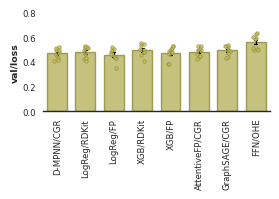

In [27]:
# choose the metric, i.e. accuracy or AUROC
metric = "val/loss"
# choose the task (0D, 1D, or 2D)
tag = "3D"
# choose the colorscheme
fill_color = (198/256, 193/256, 80/256)

stroke_color = (142/256, 136/256, 58/256)

# choose the data to plot
experiment_ids = [
    "JG1103",
    "JG1107",
    "JG1108",
    "JG1110",
    "JG1111",
    "JG1113",
    "JG1114",
    "JG1120",
]

# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(experiment_ids) & df_all['tags'].apply(lambda x: tag in x)]

# sort the values
sort_dict = dict(zip(experiment_ids, itertools.count()))
df_plot = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict))
ticklabels = df_plot["Model+Features"].unique().tolist()
# set plot
fig, ax = plt.subplots(figsize=(2.8,2))
sns.barplot(
    ax=ax,
    data=df_plot, 
    x="Model+Features",
    y=metric,
    errorbar=errorbar,
    errwidth=errwidth,
    errcolor=errcolor,
    capsize=capsize,
    color=fill_color,
    edgecolor=stroke_color,
    linewidth=linewidth,
    alpha=.8,
    width=.7,
)

sns.stripplot(
    ax=ax,
    data=df_plot, 
              x="Model+Features",
              y=metric,
              dodge=True,
              edgecolor=stroke_color,
              color=fill_color,
              linewidth=.5,
              legend=False,
              marker="o",
              size=2.5,
              alpha=.8
             )

#ax.axhline(0.5, ls="--", color=bode_palette.blue, linewidth=.7)
ax.set_xlabel(None)
ax.xaxis.set_tick_params(labelrotation=90)
ax.set_ylim((0, 0.8))
ax.xaxis.set_ticklabels(df_plot["Model+Features"].drop_duplicates().str.replace("LogisticRegression", "LogReg"))

fig.tight_layout()
fig.savefig(analysis_dir / f"metrics_{tag}_models_{metric.replace('/', '_')}.svg", format="svg")
fig.savefig(analysis_dir / f"metrics_{tag}_models_{metric.replace('/', '_')}.png", dpi=300)